# Imports

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import os

plt.rcParams['figure.figsize'] = (10.0, 7.0)
plt.rcParams["font.size"] = 16
plt.rcParams["font.family"] = "Serif"
plt.rcParams["grid.linestyle"] = "--"
plt.rcParams["grid.linewidth"] = 0.5

In [2]:
PLOTS_DIR = 'plots'

# Load The Data

In [3]:
def dataset(size=200, timesteps=25):
    """Create a dataset for a sine wave.
    
    Parameters
    ----------
    size : int, optional
        The size of the dataset. The default is 200.
    timesteps : int, optional
        The number of timesteps. The default is 25.

    Returns
    -------
    x : numpy.ndarray
        The input data.
    y : numpy.ndarray
        The output data.
    """
    x, y = [], []
    sin_wave = np.sin(np.arange(size))
    for step in range(sin_wave.shape[0] - timesteps):
        x.append(sin_wave[step : step + timesteps])
        y.append(sin_wave[step + timesteps])
    return np.array(x).reshape(len(y), timesteps, 1), np.array(y).reshape(len(y), 1)

We will be creating 300 test and 300 training examples.

In [4]:
x, y = dataset(300)
x_test, y_test = dataset(300)

Let's have a look at the shape of the data.

In [5]:
print(f"Shape of x: {x.shape}")
print(f"Shape of y: {y.shape}")

Shape of x: (275, 25, 1)
Shape of y: (275, 1)


# RNN

In [6]:
class RNN:
    """A simple RNN model for regression task"""

    def __init__(self, x, y, hidden_units):
        """Initialize the model with input and output data

        Parameters
        ----------
        x : numpy.ndarray
            Input data
        y : numpy.ndarray
            Output data
        hidden_units : int
            Number of hidden units in the RNN

        Returns
        -------
        None
        """
        self.x = x
        self.y = y
        self.hidden_units = hidden_units
        self.Wx = np.random.randn(1, hidden_units) * 0.01
        self.Wh = np.random.randn(hidden_units, hidden_units) * 0.01
        self.Wy = np.random.randn(hidden_units, y.shape[1]) * 0.01

    def cell(self, xt, ht_1):
        """The RNN cell

        Parameters
        ----------
        xt : numpy.ndarray
            Input data at time step t
        ht_1 : numpy.ndarray
            Hidden state at time step t-1

        Returns
        -------
        ht : numpy.ndarray
            Hidden state at time step t
        yt : numpy.ndarray
            Output at time step t
        """
        ht = np.tanh(np.dot(xt, self.Wx) + np.dot(ht_1, self.Wh))
        yt = np.dot(ht, self.Wy)
        return ht, yt

    def forward(self, sample):
        """The forward pass of the RNN

        Parameters
        ----------
        sample : int
            The index of the sample to be used for forward pass

        Returns
        -------
        None
        """
        sample_x, sample_y = self.x[sample], self.y[sample]
        ht = np.zeros((1, self.hidden_units))
        self.hidden_states = [ht]
        self.inputs = []
        for step in range(len(sample_x)):
            ht, yt = self.cell(sample_x[step].reshape(1, 1), ht)
            self.inputs.append(sample_x[step].reshape(1, 1))
            self.hidden_states.append(ht)
        self.error = yt - sample_y
        self.loss = 0.5 * np.sum(self.error**2)
        self.yt = yt

    def backward(self):
        """The backward pass of the RNN

        Parameters
        ----------
        None

        Returns
        -------
        None
        """
        n = len(self.inputs)
        dyt = self.error
        dWy = np.dot(self.hidden_states[-1].T, dyt)
        dht = np.dot(dyt, self.Wy.T)
        dWx = np.zeros_like(self.Wx)
        dWh = np.zeros_like(self.Wh)
        for step in reversed(range(n)):
            temp = (1 - self.hidden_states[step] ** 2) * dht
            dWx += np.dot(self.inputs[step].T, temp)
            dWh += np.dot(self.hidden_states[step - 1].T, temp)
            dht = np.dot(temp, self.Wh.T)
        dWy = np.clip(dWy, -1, 1)
        dWx = np.clip(dWx, -1, 1)
        dWh = np.clip(dWh, -1, 1)
        self.Wy -= self.lr * dWy
        self.Wx -= self.lr * dWx
        self.Wh -= self.lr * dWh

    def train(self, epochs, learning_rate, verbose=2):
        """The training loop of the RNN

        Parameters
        ----------
        epochs : int
            Number of epochs to train the model
        learning_rate : float
            Learning rate of the model

        Returns
        -------
        None
        """
        self.Ovr_loss = []
        self.lr = learning_rate
        for epoch in range(epochs):
            for sample in range(self.x.shape[0]):
                self.forward(sample)
                self.backward()
            epoch_loss = np.mean(self.loss)
            self.Ovr_loss.append(epoch_loss)
            if verbose == 1:
                if (epoch + 1) % 100 == 0:
                    print(f"Epoch: {epoch + 1} | Loss: {epoch_loss:.6e}")
            elif verbose == 2:
                if (epoch + 1) % 10 == 0:
                    print(f"Epoch: {epoch + 1} | Loss: {epoch_loss:.6e}")
            elif verbose > 3:
                print(f"Epoch: {epoch + 1} | Loss: {epoch_loss:.6e}", end="\r")
            if epoch == 0:
                print(f"Epoch: {epoch + 1} | Loss: {epoch_loss:.6e}")
            self.loss = 0

    def test(self, x, y):
        """The testing loop of the RNN

        Parameters
        ----------
        x : numpy.ndarray
            Input data
        y : numpy.ndarray
            Output data

        Returns
        -------
        loss : float
            The loss of the model on the test set
        """
        self.x = x
        self.y = y
        self.outputs = []
        for sample in range(len(x)):
            self.forward(sample)
            self.outputs.append(self.yt)
        self.outputs = np.array(self.outputs).reshape(len(y), 1)
        self.y = self.y.reshape(len(y), 1)
        self.error = self.outputs - self.y
        self.loss = 0.5 * np.mean(self.error**2)
        print(f"Test Loss: {self.loss:.5e}")
        return self.loss

Let's train the model for 50 epochs:

In [7]:
epochs = 50
rnn = RNN(x, y, 100)
rnn.train(50, 1e-2)

Epoch: 1 | Loss: 1.412302e-01
Epoch: 10 | Loss: 2.788352e-09
Epoch: 20 | Loss: 2.372980e-07
Epoch: 30 | Loss: 2.074985e-07
Epoch: 40 | Loss: 1.778373e-07
Epoch: 50 | Loss: 1.486742e-07


We can see that even for 10 epoch, the loss has gone down to a very small value.

# Plots

Let's plot the loss as well as the predictions. Here is the loss plot:

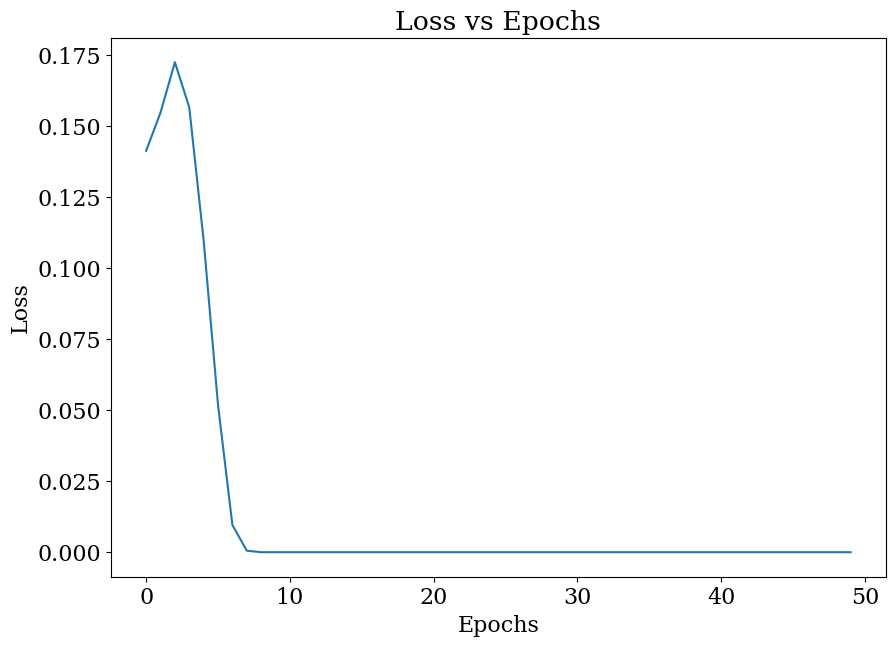

In [8]:
plt.plot(rnn.Ovr_loss)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.savefig(os.path.join(PLOTS_DIR, "0101.png"))

We can see that the loss is going down very quickly and becomes almost zero after 10 epochs. This is why I've trained it for only 50 epochs.

Let's evaluate the model on test dataset and plot the prediction along with the actual values.

In [9]:
loss = rnn.test(x_test, y_test)

Test Loss: 2.28096e-05


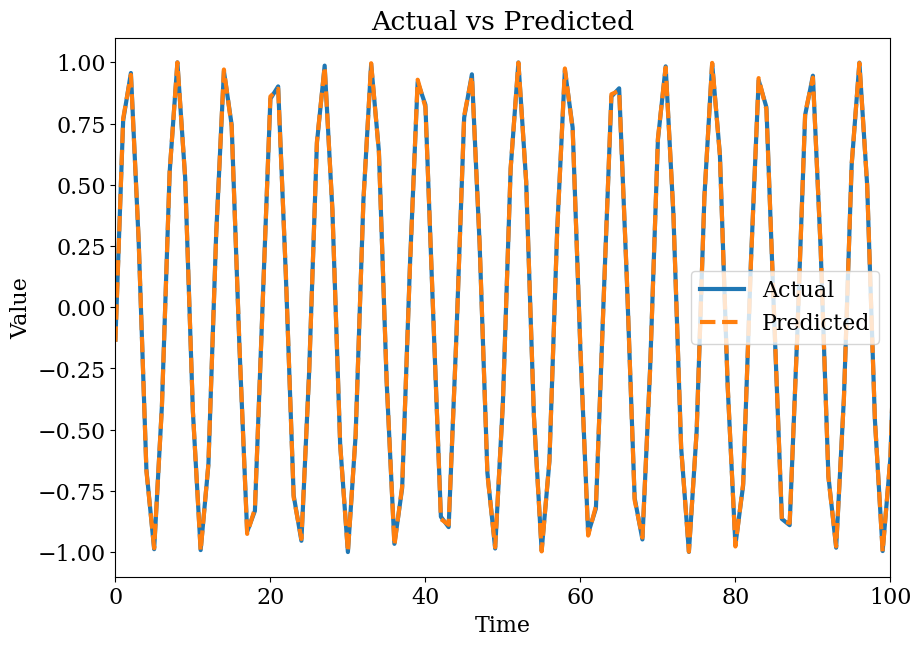

In [10]:
y_pred = rnn.outputs
plt.plot(y_test, label="Actual", linestyle="-", linewidth=3)
plt.plot(y_pred, label="Predicted", linestyle="--", linewidth=3)
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Actual vs Predicted")
plt.xlim(0, 100)
plt.legend()
plt.savefig(os.path.join(PLOTS_DIR, "0102.png"))

We can see a *perfect* match between the actual and predicted values.